# Calculate the merger rate 

In [1]:
import numpy as np, astropy, scipy, glob, sys
import matplotlib.pyplot as pl
from scipy.optimize import curve_fit
from scipy.misc import factorial
import scipy.signal as sig
import scipy.stats as st
from scipy.interpolate import interp1d
#import seaborn

import plot_conf_int
import dosurvey, populate

#%pylab
%matplotlib inline

## Start calculating the likelihoods and merger rates

In [3]:
def get_pop_pdfs(N_tots, alphas):
    #Function to get pdfs for population numbers
    
    pop_pdfs = np.full((len(alphas), len(N_tots)), 0.0)
    
    for ii, aa in enumerate(alphas):
        
        #Eq. 9 in the paper:
        pop_pdfs[ii] = aa ** 2 * N_tots * np.exp(-1 * aa * N_tots)
    
    return pop_pdfs

def get_rate_pdfs(N_tots, N_psr, alphas, t_life, f_b):
    #Function for calculating rates and rate pdfs
    
    #Initialize variables to hold the output
    rates = np.full((len(N_psr), len(N_tots)), 0.0)
    rate_pdfs = np.full(np.shape(rates), 0.0)
    
    for ii in range(len(N_psr)):
        
        #Eq. 10 in the paper:
        rates[ii] = N_tots * f_b[ii] / t_life[ii]
        
        #Eq. 11 in the paper:
        rate_pdfs[ii] = (alphas[ii] * t_life[ii] / f_b[ii]) ** 2 * rates[ii] * np.exp(-1 * (alphas[ii] * t_life[ii] / f_b[ii]) * rates[ii])
        
        #Normalize the above pdf:
        rate_pdfs[ii] = rate_pdfs[ii] / (scipy.integrate.simps(rate_pdfs[ii], rates[ii]))
        
    return rates, rate_pdfs

### Plug in the numbers from our analysis into above function to calculate the merger rate.

We also list the different numbers corresponding to the different test case scenarios described in the Discussion section.

In [4]:
names = np.array([r'B1913+16', r'B1534+12', r'J1757$-$1854', 'J1946+2052', '1913+1102', r'J0737$-$3039A', 'J1756$-$2251', 'J1906$-$0746'])

N_tots = np.linspace(10, 4e3, 1000)

#Correct alphas
alphas = np.array([0.00356455, 0.00599778, 0.00466759, 0.00442606, 0.00487211, 0.00242033, 0.00604415, 0.01117695])
#decrease mean luminosity alphas
#alphas = np.array([0.00290474, 0.00479277, 0.00302507, 0.002158, 0.00319983, 0.00124934, 0.00424225, 0.00947576])

#Correct n_psr
N_psr = np.array([281, 167, 214, 226, 205, 413, 165, 89])
#decrease mean luminosity n_psr
#N_psr = np.array([344, 209, 331, 463, 313, 800, 236, 106])

#t_life using the GW coalescence time for J1906+0746 as its death time:
#t_life = np.array([0.37e3, 2.93e3, 0.162e3, 0.293e3, 3.125e3, 0.24e3, 1.69e3, 0.3e3])
#t_life using the time for 1906 to cross into the death valley, with eq. 6 and 9 and Dunc's (FIDUCIAL) eq. resp.
#t_life = np.array([0.37e3, 2.93e3, 0.162e3, 0.293e3, 3.125e3, 0.24e3, 1.69e3, 0.003e3])
#t_life = np.array([0.37e3, 2.93e3, 0.162e3, 0.293e3, 3.125e3, 0.24e3, 1.69e3, 0.03e3])
# FIDUCIAL
t_life = np.array([0.37e3, 2.93e3, 0.162e3, 0.293e3, 3.125e3, 0.24e3, 1.69e3, 0.06e3]) 

#Correct f_b
f_b = np.array([5.72, 6.04, 4.59, 4.59, 4.59, 2.00, 4.59, 4.59])
#Overestimate f_b:
#f_b = np.array([5.72, 6.04, 24, 24, 24, 2.00, 24, 24])
#f_b = np.array([5.72, 6.04, 10, 10, 10, 2.00, 10, 10])

pop_pdfs = get_pop_pdfs(N_tots, alphas)

rates, rate_pdfs = get_rate_pdfs(N_tots, N_psr, alphas, t_life, f_b)

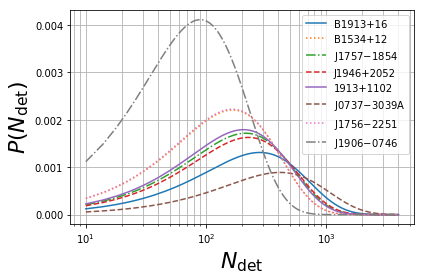

In [5]:
#Plot probability distributions for the individual populations

linestyles = ['-', ':', '-.', '--', '-', '--', ':', '-.']

for ii, vals in enumerate(pop_pdfs):
    
    pl.plot(N_tots, vals, label = names[ii], ls = linestyles[ii])
    #plot_conf_int.plot_area_under_curve(N_tots, vals, xlabel = r"$N_{\rm tot}$", ylabel = r"$P(N_{\rm tot})$", label = names[ii])
    
pl.xscale('log')

pl.xlabel(r"$N_{\rm det}$", fontsize = 22)
pl.ylabel(r"$P(N_{\rm det})$", fontsize = 22)

pl.grid(True, which = 'both')
pl.tight_layout()

pl.legend(loc = 'best')

#pl.savefig("/home/npol/Pictures/merger_rate/latest/obervable_pop.pdf")

pl.show()

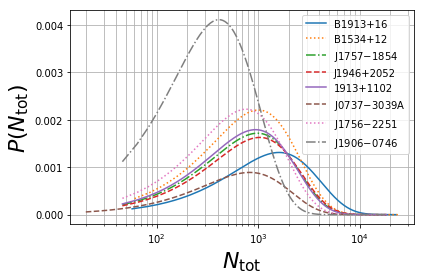

In [15]:
#Plot the TOTAL DNS distribution for each DNS system

linestyles = ['-', ':', '-.', '--', '-', '--', ':', '-.']

for ii, vals in enumerate(pop_pdfs):
    
    pl.plot(N_tots * f_b[ii], vals, label = names[ii], ls = linestyles[ii])
    #plot_conf_int.plot_area_under_curve(N_tots * f_b[ii], vals, xlabel = r"$N_{\rm tot}$", ylabel = r"$P(N_{\rm tot})$", label = names[ii])
    
pl.xscale('log')

pl.xlabel(r"$N_{\rm tot}$", fontsize = 22)
pl.ylabel(r"$P(N_{\rm tot})$", fontsize = 22)

pl.grid(True, which = 'both')
pl.tight_layout()

pl.legend(loc = 'best')

#pl.savefig("/home/npol/Pictures/merger_rate/latest/total_population.pdf")

pl.show()

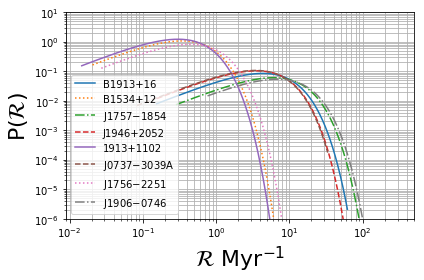

In [7]:
#Plot probability distributions for individual rate contributions

linestyles = ['-', ':', '-.', '--', '-', '--', ':', '-.']

for ii, vals in enumerate(rate_pdfs):
    
    pl.loglog(rates[ii], vals, label = names[ii], ls = linestyles[ii])
    #plot_conf_int.plot_area_under_curve(rates[ii], vals, label = names[ii], xlabel = r"$\cal{R}$", ylabel = r"P($\cal{R}$)")
    
pl.ylim(1e-6, 10)
    
pl.xlabel(r"$\cal{R}$ Myr$^{-1}$", fontsize = 22)
pl.ylabel(r"P($\cal{R}$)", fontsize = 22)

pl.grid(True, which = 'both')
pl.tight_layout()

pl.legend(loc = 'best')

#pl.savefig("/home/npol/Pictures/merger_rate/latest/individual_rates.pdf")

pl.show()

- Here I convert the PDFs obtained above into Scipy discrete random variables (RVs) for slightly easier computation

In [5]:
#Take each DNS system; get integer rates; create rvs distribution:

def get_rvs_dist(rates_array, pdf_array, name_dns = 'rvs'):
    
    #Interpolate the original rates and pdfs to get function
    norm_pdf = pdf_array / scipy.integrate.simps(pdf_array, rates_array)
    func = interp1d(rates_array, norm_pdf)
    
    #Find minimum and maximum integer rates for this DNS
    min_rate = np.int(np.min(rates_array) + 1)
    max_rate = np.int(np.max(rates_array) - 1)
    
    #Make new integer array:
    new_rate_array = np.arange(min_rate, max_rate, 1)
    
    #Get the rate probability at these integer rates:
    new_pdf = func(new_rate_array)
    #Normalize this new pdf:
    new_pdf_norm = new_pdf / np.sum(new_pdf)
    
    #Define an RVS for this binary:
    return st.rv_discrete(name = name_dns, values = (new_rate_array, new_pdf_norm))

- The discrete RV definition helps simplify the addition:

In [6]:
def add_two_rvs(x1, y1, x2, y2):
    
    #Make sure x1 and x2 are integer arrays:
    #if np.any(np.issubdtype(x1, np.int)) or np.any(np.issubdtype(x2, np.int)):
    #    sys.exit("Your input X-arrays are not integer arrays!")
    
    #Normalize the input pdfs
    y1_norm = y1 / scipy.integrate.simps(y1, x1)
    y2_norm = y2 / scipy.integrate.simps(y2, x2)
    
    #Create a discrete rvs for the two pdfs given
    rvs1 = get_rvs_dist(x1, y1)
    rvs2 = get_rvs_dist(x2, y2)
    
    #Create a common footing for both rvs so that convolution makes sense
    common_foot = np.arange(np.int(np.min([min(x1), min(x2)])), np.int(np.max([max(x1), max(x2)])), 1)
    #common_foot = np.arange(0, 200, 1)
    common_step_size = common_foot[1] - common_foot[0]
    
    #Get new pdfs using common footing
    new_y1 = rvs1.pmf(common_foot)
    new_y2 = rvs2.pmf(common_foot)
    
    #Convolve the two pdfs
    op_pdf = sig.convolve(new_y1, new_y2)
    
    #Compute the new X-axis:
    op_x = np.arange(common_foot[0], common_foot[0] + len(op_pdf) * common_step_size, common_step_size)
    
    return op_x, op_pdf


- Using the above two functions, calculate the total merger rate:

0.05


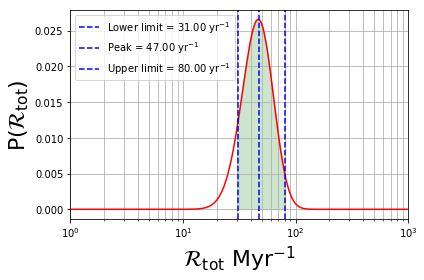

In [7]:
rates_1913_1534, rate_pdf_1913_1534 = add_two_rvs(rates[0], rate_pdfs[0], rates[1], rate_pdfs[1])
rates_1757_1946, rate_pdf_1757_1946 = add_two_rvs(rates[2], rate_pdfs[2], rates[3], rate_pdfs[3])
rates_nearly_almost_all, rate_pdf_nearly_almost_all = add_two_rvs(rates_1913_1534, rate_pdf_1913_1534, rates_1757_1946, rate_pdf_1757_1946)

rates_almost_all, pdf_almost_all = add_two_rvs(rates[4], rate_pdfs[4], rates_nearly_almost_all, rate_pdf_nearly_almost_all)

rates_all, pdf_all = add_two_rvs(rates_almost_all, pdf_almost_all, rates[5], rate_pdfs[5])

rates_next_to_last, pdf_next_to_last = add_two_rvs(rates_all, pdf_all, rates[6], rate_pdfs[6])

rates_final, pdf_final = add_two_rvs(rates_next_to_last, pdf_next_to_last, rates[7], rate_pdfs[7])

plot_conf_int.plot_area_under_curve(rates_final, pdf_final, conf_int = 0.90)
#plot_conf_int.plot_area_under_curve(rates_all, pdf_all)

pl.xscale('log')
pl.xlim(0, 1e3)

pl.grid(True, which = 'both')
pl.tight_layout()

#pl.savefig("/home/npol/Pictures/merger_rate/latest/mw_merger_rate.pdf")


- Convert the total galactic rate to the LIGO detection rate

0.05


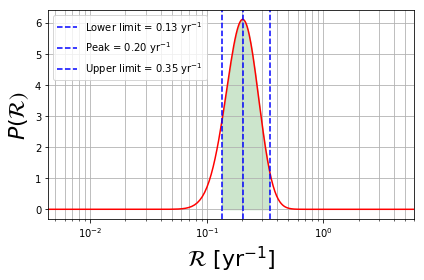

In [9]:
#Method from Koparappu, et al. 2008

d_r = 100 #range distance in Mpc
L_mw = 1.7
r_mw = rates_final / L_mw

ligo_rates = 7.4e-3 * (r_mw) * (2.26 * d_r / 100.) ** 3 #* 1.5
 ### Extra factor of 2.26 is to convert from range to horizon distance (see An Updated Galactic Double Neutron Star Merger Rate Based on Radio Pulsar Populations, Pol et al., 2020)
plot_conf_int.plot_area_under_curve(ligo_rates, pdf_final, conf_int = 0.90, xlabel = r'$\cal{R}$ [yr$^{-1}$]', ylabel = r'$P(\cal{R})$')

pl.xscale('log')
pl.xlim(0, 6)

pl.grid(True, which = 'both')
pl.tight_layout()

pl.savefig("/home/npol/Pictures/merger_rate/latest/complete_LIGO_rate.pdf")


- The code below this is used for generating figures 5 and 6 in the paper:

In [7]:
#Make a nice 1-D plot to compare LIGO and our rate:
our_rates = np.array([0.20])
ul = np.array([0.15])
ll = np.array([0.07])

lf_rate = np.array([0.30]) #Luminosity function variation
lf_ll = np.array([0.10])
lf_ul = np.array([0.20])

ligo_rate = np.array([1.54]) #LIGO rate
ligo_ll = np.array([1.22])
ligo_ul = np.array([3.20])

bf_rate = np.array([0.35]) #Beaming factor variation, bf_new = 10
bf_ul = np.array([0.3])
bf_ll = np.array([0.13])

ellip_rate = np.array([0.31]) #Include elliptical galaxy contribution
ellip_ul = np.array([0.21])
ellip_ll = np.array([0.11])

allover_rate = np.array([0.45]) # All of the above corrections, except beaming factor, together
allover_ul = np.array([0.31])
allover_ll = np.array([0.16])

cli_rate = np.array([0.6]) #Chruslinska rate
cli_ul = np.array([1.2])
cli_ll = np.array([0.3])

map_rate = np.array([0.30]) #Mapelli rate
map_ul = np.array([0.30])
map_ll = np.array([0.28])



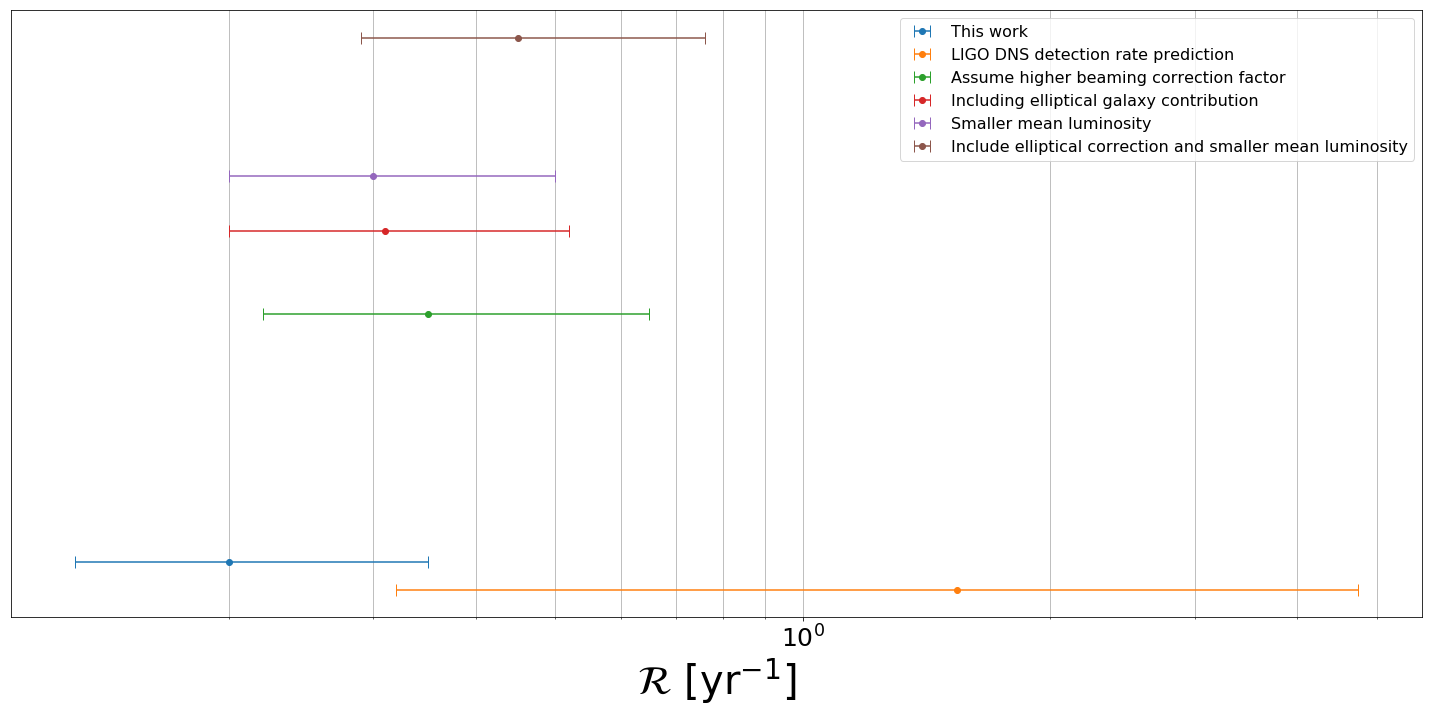

In [12]:
#Plot all the above
#pl.errorbar(np.arange(0, len(rates)), rates, yerr = [lol, upl], fmt = 'o', ls = '')
pl.figure(figsize = (20, 10))
l0a, caps1, c1 = pl.errorbar(our_rates, 0.01, xerr = [ll, ul], fmt = 'o', capsize = 6, label = 'This work')
l0b, caps2, c2 = pl.errorbar(ligo_rate, 0, xerr = [ligo_ll, ligo_ul], fmt = 'o', capsize = 6, label = 'LIGO DNS detection rate prediction')

l3, caps3, c3 = pl.errorbar(bf_rate, 0.1, xerr = [bf_ll, bf_ul], fmt = 'o', capsize = 6, label = 'Assume higher beaming correction factor')
l4, caps4, c4 = pl.errorbar(ellip_rate, 0.13, xerr = [ellip_ll, ellip_ul], fmt = 'o', capsize = 6, label = 'Including elliptical galaxy contribution')

l3, caps3, c3 = pl.errorbar(lf_rate, 0.15, xerr = [lf_ll, lf_ul], fmt = 'o', capsize = 6, label = 'Smaller mean luminosity')

l4, caps4, c4 = pl.errorbar(allover_rate, 0.2, xerr = [allover_ll, allover_ul], fmt = 'o', capsize = 6, label = 'Include elliptical correction and smaller mean luminosity')

pl.xscale('log')

pl.xlabel(r'$\cal{R}$ [yr$^{-1}$]', fontsize = 40)

#This turns off the tick marks for y-axis
pl.setp(pl.gca(), yticks=())
pl.xticks(fontsize = 25)

pl.grid(True, which = 'both')

pl.legend(loc = 'best', frameon = True, fontsize = 16)
pl.tight_layout()

#pl.savefig("/home/npol/Pictures/merger_rate/latest/sim_var.pdf")

pl.show()

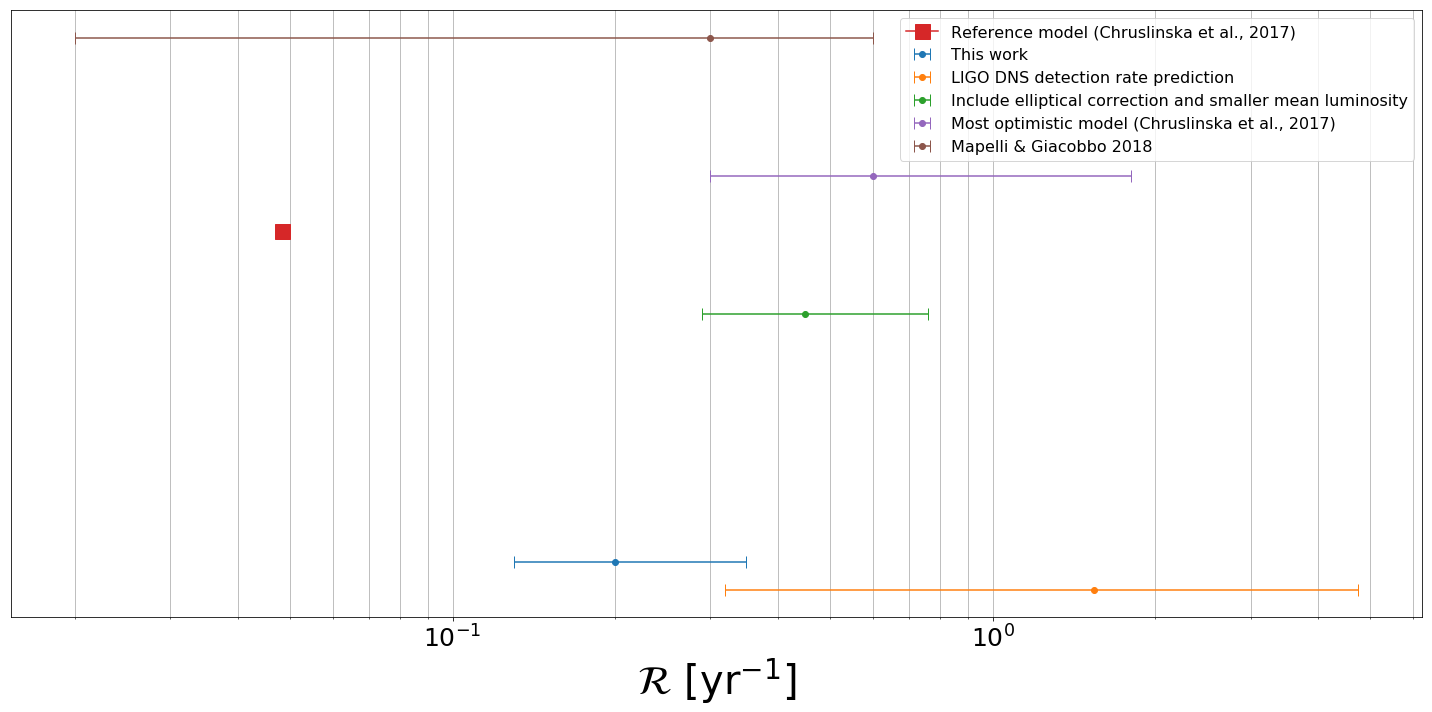

In [9]:
pl.figure(figsize = (20, 10))
l0a, caps1, c1 = pl.errorbar(our_rates, 0.01, xerr = [ll, ul], fmt = 'o', capsize = 6, label = 'This work')
l0b, caps2, c2 = pl.errorbar(ligo_rate, 0, xerr = [ligo_ll, ligo_ul], fmt = 'o', capsize = 6, label = 'LIGO DNS detection rate prediction')

pl.xscale('log')

pl.xlabel(r'$\cal{R}$ [yr$^{-1}$]', fontsize = 40)

#Add the chrusylinski and mapelli merger rates:
l1, caps4, c4 = pl.errorbar(allover_rate, 0.1, xerr = [allover_ll, allover_ul], fmt = 'o', capsize = 6, label = 'Include elliptical correction and smaller mean luminosity')

l2 = pl.plot(0.0484, 0.13, marker = 's', markersize = 15, label = 'Reference model (Chruslinska et al., 2017)')
l3, caps4, c4 = pl.errorbar(cli_rate, 0.15, xerr = [cli_ll, cli_ul], fmt = 'o', capsize = 6, label = 'Most optimistic model (Chruslinska et al., 2017)')

l4, caps4, c4 = pl.errorbar(map_rate, 0.2, xerr = [map_ll, map_ul], fmt = 'o', capsize = 6, label = 'Mapelli & Giacobbo 2018')

#This turns off the tick marks for y-axis
pl.setp(pl.gca(), yticks=())
pl.xticks(fontsize = 25)

pl.grid(True, which = 'both')

pl.legend(loc = 'best', frameon = True, fontsize = 16)
pl.tight_layout()

#pl.savefig("/home/npol/Pictures/merger_rate/latest/comp_diff_rates.pdf")

pl.show()